# 추천시스템 개요
## 추천시스템의 중요성
아마존과 같은 전자상거래부터 넷플릭스, 유튜브, 애플 뮤직 등 콘텐츠 포털까지 추천 시스템을 통해 **사용자의 취향을 이해**하고 맞춤 상품과 콘텐츠를 제공해 조금이라도 오랫동안 자기 사이트에 고객을 머무르게 하기 위해 전력을 기울이고 있습니다.

## 추천엔진의 필요성
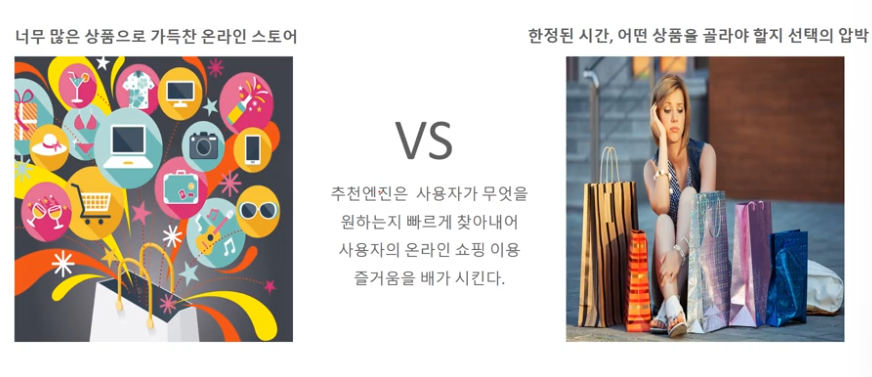

## 추천 시스템의 묘미
사용자 **로 좋아하는지 모르고 있었던 취향을 발견하는 것**다. 추천 시스템에 신뢰가 높아지면서 사용자는 추천 아이템을 더많이 선택하게 되고, 이로 인해 더 많은 데이터가 추천 시스템에 축적되면서 추천이 정확해지고 다양해집니다.

## 추천 시스템 방식
추천 시스템은 아래 방식 중 1가지를 선택하거나 결합한 **hybrid** 방식(대표적인 예시가 넷플릭스)으로 사용합니다.
##### 1. 콘텐츠 기반 필터링(Content Based Filtering)
##### 2. 협업 필터링(Collaborative Filtering)

# 콘텐츠 기반 필터링(Contents Based Filtering)
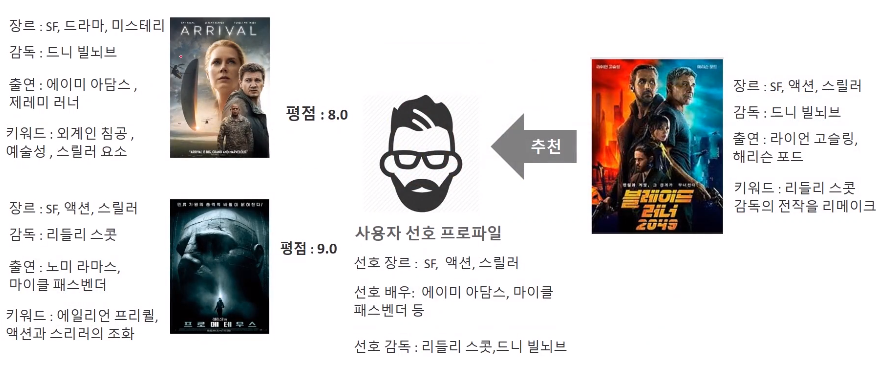

## 콘텐츠 기반 필터링 기법
감독, 배우, 영화 설명, 장르 등 영화를 구성하는 다양한 콘텐츠들을 **텍스트 기반 문서 유사도**로 비교하여 추천

##### 영화 구성 콘텐츠 텍스트 > 피처 벡터화(Count, TF-IDF) > 코사인 유사도 > 유사도 및 평점에 따른 영화 추천

## 콘텐츠 기반 필터링 실습
1. 콘텐츠에 대한 여러 텍스트 정보들을 피처 벡터화
2. 코사인 유사도로 콘텐츠별 유사도 계산
3. 콘텐츠 별로 가중 평점 계산
4. 유사도가 높은 콘텐츠 중에 평점이 좋은 콘텐츠 순으로 추천

## 실습

### 9.1 컨텐츠 기반 필터링 실습 – TMDB 5000 Movie Dataset

In [1]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies =pd.read_csv('./tmdb-5000-movie-dataset/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                      homepage     id  \
0  http://www.avatarmovie.com/  19995   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   

  original_title                                           overview  \
0         Avatar  In the 22nd century, a paraplegic Marine is di...   

   popularity                               production_companies  \
0  150.437577  [{"name": "Ingenious Film Partners", "id": 289...   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   

   runtime                                   spoken_languages    status  \
0    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   

                       tagline   title  vote_average  vote_count  
0  Enter the World of Pandora.  Avatar           7.2       11800

In [2]:
movies_df = movies[['id','title', 'genres', 'vote_average', 'vote_count',
                 'popularity', 'keywords', 'overview']]


In [3]:
pd.set_option('max_colwidth', 100)
movies_df[['genres','keywords']][:1]


genres  \
0  [{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {...   

                                                                                              keywords  
0  [{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "sp...

In [4]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 8 columns):
id              4803 non-null int64
title           4803 non-null object
genres          4803 non-null object
vote_average    4803 non-null float64
vote_count      4803 non-null int64
popularity      4803 non-null float64
keywords        4803 non-null object
overview        4800 non-null object
dtypes: float64(2), int64(2), object(4)
memory usage: 300.3+ KB


**텍스트 문자 1차 가공. 파이썬 딕셔너리 변환 후 리스트 형태로 변환**

In [5]:
from ast import literal_eval

movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

In [6]:
movies_df['genres'].head(1)

0    [{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {...
Name: genres, dtype: object

In [7]:
movies_df['genres'] = movies_df['genres'].apply(lambda x : [ y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [ y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

genres  \
0  [Action, Adventure, Fantasy, Science Fiction]   

                                                                                              keywords  
0  [culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa...

**장르 콘텐츠 필터링을 이용한 영화 추천. 장르 문자열을 Count 벡터화 후에 코사인 유사도로 각 영화를 비교**

**장르 문자열의 Count기반 피처 벡터화**

In [15]:
type(('*').join(['test', 'test2']))

str

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환. 
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=0, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


**장르에 따른 영화별 코사인 유사도 추출**

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])


(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]


In [18]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


**특정 영화와 장르별 유사도가 높은 영화를 반환하는 함수 생성**

In [20]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    
    # 인자로 입력된 movies_df DataFrame에서 'title' 컬럼이 입력된 title_name 값인 DataFrame추출
    title_movie = df[df['title'] == title_name]
    
    # title_named을 가진 DataFrame의 index 객체를 ndarray로 반환하고 
    # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n 개의 index 추출
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n)]
    
    # 추출된 top_n index들 출력. top_n index는 2차원 데이터 임. 
    #dataframe에서 index로 사용하기 위해서 1차원 array로 변경
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)
    
    return df.iloc[similar_indexes]


In [21]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


title  vote_average
2731                          The Godfather: Part II           8.3
1243                                    Mean Streets           7.2
3636                                   Light Sleeper           5.7
1946  The Bad Lieutenant: Port of Call - New Orleans           6.0
2640         Things to Do in Denver When You're Dead           6.7
4065                                      Mi America           0.0
1847                                      GoodFellas           8.2
4217                                            Kids           6.8
883                              Catch Me If You Can           7.7
3866                                     City of God           8.1

**평점이 높은 영화 정보 확인**

In [22]:
movies_df[['title','vote_average','vote_count']].sort_values('vote_average', ascending=False)[:10]

title  vote_average  vote_count
3519          Stiff Upper Lips          10.0           1
4247     Me You and Five Bucks          10.0           2
4045     Dancer, Texas Pop. 81          10.0           1
4662            Little Big Top          10.0           1
3992                 Sardaarji           9.5           2
2386            One Man's Hero           9.3           2
2970        There Goes My Baby           8.5           2
1881  The Shawshank Redemption           8.5        8205
2796     The Prisoner of Zenda           8.4          11
3337             The Godfather           8.4        5893

**평가 횟수에 대한 가중치가 부여된 평점(Weighted Rating) 계산  
         가중 평점(Weighted Rating) = (v/(v+m)) * R + (m/(v+m)) * C**
         
■ v: 개별 영화에 평점을 투표한 횟수
■ m: 평점을 부여하기 위한 최소 투표 횟수
■ R: 개별 영화에 대한 평균 평점.
■ C: 전체 영화에 대한 평균 평점

In [23]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:',round(C,3), 'm:',round(m,3))

C: 6.092 m: 370.2


In [24]:
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
    v = record['vote_count']
    R = record['vote_average']
    
    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )   

movies_df['weighted_vote'] = movies_df.apply(weighted_vote_average, axis=1) 


In [25]:
movies_df[['title','vote_average','weighted_vote','vote_count']].sort_values('weighted_vote',
                                                                          ascending=False)[:10]


title  vote_average  weighted_vote  vote_count
1881  The Shawshank Redemption           8.5       8.396052        8205
3337             The Godfather           8.4       8.263591        5893
662                 Fight Club           8.3       8.216455        9413
3232              Pulp Fiction           8.3       8.207102        8428
65             The Dark Knight           8.2       8.136930       12002
1818          Schindler's List           8.3       8.126069        4329
3865                  Whiplash           8.3       8.123248        4254
809               Forrest Gump           8.2       8.105954        7927
2294             Spirited Away           8.3       8.105867        3840
2731    The Godfather: Part II           8.3       8.079586        3338

In [26]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    title_movie = df[df['title'] == title_name]
    title_index = title_movie.index.values
    
    # top_n의 2배에 해당하는 쟝르 유사성이 높은 index 추출 
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1)
# 기준 영화 index는 제외
    similar_indexes = similar_indexes[similar_indexes != title_index]
    
    # top_n의 2배에 해당하는 후보군에서 weighted_vote 높은 순으로 top_n 만큼 추출 
    return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title', 'vote_average', 'weighted_vote']]


title  vote_average  weighted_vote
2731       The Godfather: Part II           8.3       8.079586
1847                   GoodFellas           8.2       7.976937
3866                  City of God           8.1       7.759693
1663  Once Upon a Time in America           8.2       7.657811
883           Catch Me If You Can           7.7       7.557097
281             American Gangster           7.4       7.141396
4041              This Is England           7.4       6.739664
1149              American Hustle           6.8       6.717525
1243                 Mean Streets           7.2       6.626569
2839                     Rounders           6.9       6.530427